In [ ]:
# Replication_profiles by Marco Fumasoni
# This script was written to visualize the genome-wide replication profiles of strains obtained by whole-genome sequencing
# The scriped was written starting from "plot_tumor_depth_all_chromosome.py" of unknown origin
#
# NOTE
# The code is made available for transparency reasons. At present, it is not intended to be readily usable on different datasets. 
# Also, it was not annotated and compiled to be user-friendly. Please, contact me privately for any inquiry related to the code usage.
# I will maintain this code with improved versions as soon as they are developed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
import glob, os
import sys
#import seaborn as sns
from scipy.stats import mode
from matplotlib.patches import Rectangle
import math
import pandas as pd
%matplotlib inline

In [2]:
def convert_nan_to_one(array):
        return np.array([1 if math.isnan(x) else x for x in array])

In [3]:
def explore_copynumbers(file):
# load the varscan dataset
    datafn=file

    # Read in the start position and log2_ratio for each window, saving each chromosome separately
    # Initialize a dictionary to hold the data, arranged by chromosome
    chrom_dict = {}
    with open(datafn) as datafile:
        # The first line of the file is the header line. Store in variable `header,' which we will ignore.
        header = datafile.readline()
        # Read the file one line at a time
        for line in datafile:
            # The first position in the line gives the chromosome
            chrom = line.split()[0]
            # If we don't already have an entry for the chromosome in our dictionary, create an entry.
            # The entry consists of two empty lists, one will hold the start positions and one will hold the coverage
            if chrom not in chrom_dict:
                chrom_dict[chrom] = ([], [],[],[])
            # Store the start position, coverage_ratio,normal_depth,tumor_depth in their respective lists
            chrom_dict[chrom][0].append(int(line.split()[1]))
            chrom_dict[chrom][1].append(float(line.split()[-2]))
            chrom_dict[chrom][2].append(float(line.split()[-4]))
            chrom_dict[chrom][3].append(float(line.split()[-3]))

    genome_list_anc = []
    genome_list_evo = []

    

    #store alpha factor read depth for entire genome
    #calculate the median of read depth across the whole genome
    for value in chrom_dict.itervalues():
        genome_list_anc.extend(value[2])

    genome_array_anc = np.array(genome_list_anc)
    genome_median_anc = np.median(genome_array_anc)

    # store time point depth for entire genome
    #calculate the median of read depth across the whole genome
    for value in chrom_dict.itervalues():
        genome_list_evo.extend(value[3])

    genome_array_evo = np.array(genome_list_evo)
    genome_median_evo = np.median(genome_array_evo)

    chrom_list = sorted(chrom_dict.keys())
    x_vals = []
    y_vals = []
    x_vals_anc = []
    y_vals_anc = []
    x_vals_evo = []
    y_vals_evo = []
    for chrom in chrom_list:
        # Get the start positions and coverage ratio from our dictionary.
        # Convert the data from lists to numpy arrays (better for mathematical operations and plotting)
        start = np.array(chrom_dict[chrom][0])
        cov_ratio = np.array(chrom_dict[chrom][1])
        anc_depth = np.array(chrom_dict[chrom][2])
        evo_depth = np.array(chrom_dict[chrom][3])

        # Normalize by median of genome depth to control for difference sequencing depths
        normalized_depth_anc = anc_depth / genome_median_anc
        normalized_depth_evo = evo_depth / genome_median_evo
        normalized_depth = (normalized_depth_evo) / (normalized_depth_anc)

        # Calculate smoothed coverage over different window sizes for the normalized evo genome

        smoothed = np.zeros((start[-1] / W) + 1)
        n_bins = np.zeros_like(smoothed)
        for i in range(len(normalized_depth)):
            smoothed[start[i]/W] += normalized_depth[i]
            n_bins[start[i]/W] += 1
        smoothed /= n_bins

        x_vals.append(W*np.arange(len(smoothed)))
        y_vals.append(smoothed)


    

    #get the names of the two genomes compared
    anc_text = file.partition("_vs_")[0]
    evo_text = file.partition("_vs_")[2]

    #for i in range(len(y_vals)):
    #    y_vals[i]= np.log2(y_vals[i])

    # create two 2D arrays to store the centromere coordinates and the relative read depth
    x_vals_cen = []
    y_vals_cen = []

    return x_vals, y_vals
    

In [4]:
def plot_profiles(fold):
    print(fold)
    y_files = []
    x_files = []
    # Find the .copynumber files in the folder and generate 3 pdf for each file
    os.chdir(fold)
    
    for file_ in glob.glob("*.copynumber"):
        x_vals, y_vals = explore_copynumbers(file_)
        #save y_vals and x_vals in a list
        y_files.append(y_vals)
        x_files.append(x_vals)

    exp_data=pd.read_csv('ratios.csv')
    ratios = list(exp_data['ratio'])

    y_files_2=[[],[],[]]
    y_files_2[0] = [(convert_nan_to_one(yf))*ratios[0] for yf in y_files[0]]
    y_files_2[1] = [(convert_nan_to_one(yf))*ratios[1] for yf in y_files[1]]
    y_files_2[2] = [(convert_nan_to_one(yf))*ratios[2] for yf in y_files[2]]

    w,p = 201,3
    from scipy.signal import savgol_filter as savgol
    y_files_3 = [[],[],[]]
    for ii in [0,1,2]:
        y_files_3[ii] = [savgol(yf, w, p) for yf in y_files_2[ii]]

    #plt.plot(y_files_2[1][0],'.', color ='orange')
    #plt.plot(y_files_3[1][0],'.', color ='green')
    
    trep_list = y_files_3[0]
    for m in range(0, 16):
        trep_list_chr=[]
        for index in range(0, min([len(y_files_3[0][m]),len(y_files_3[1][m]),len(y_files_3[2][m])])):
            c1 = y_files_3[0][m][index]
            c2 = y_files_3[1][m][index]
            c3 = y_files_3[2][m][index]
            if c2 > 1.5:
                trep = (30-15)/(c2-c1) * (1.5-c2)+30
            else:
                if c3>= 1.5:
                    trep = (45-30)/(c3-c2) * (1.5-c3)+45
                else:
                    trep = 'nan'
            trep_list[m][index]=trep
    
    os.chdir('..//')
    
    return x_files[0],trep_list
    
    
    for ii in x_files:
        print(fold, len(ii[1]))


yMF100b
yMF100b
yMF117a
yMF117a
yMF441a
yMF441a
yMF316a
yMF316a


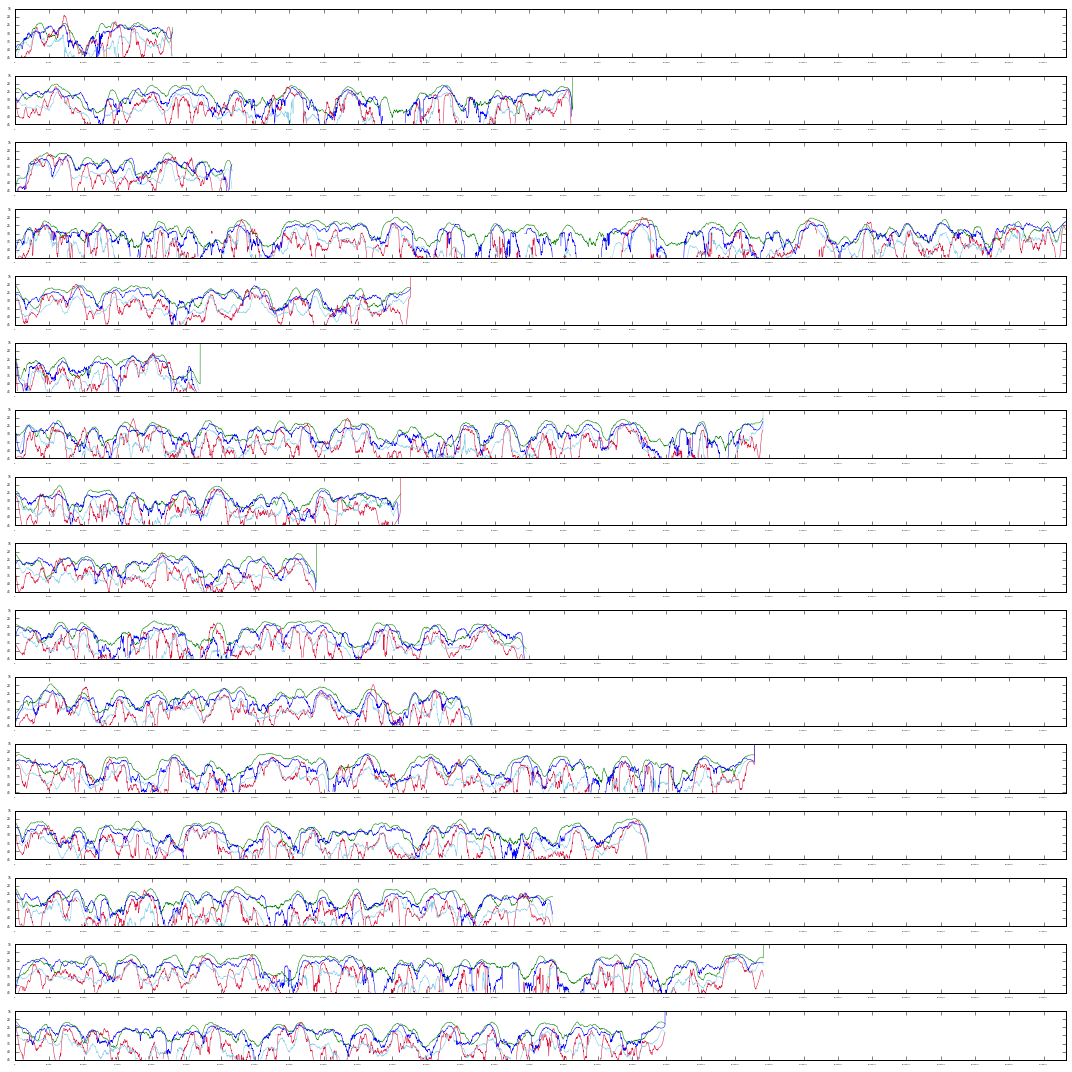

In [16]:

os.chdir(r'C:\Users\Marco\Desktop\Python\Copynumber\replication_profiles')

#filenames = os.listdir(".") # get all files' and folders' names in the current directory
#filenames.remove('.ipynb_checkpoints')
#filenames.remove('Trial')
folders = []
folders = ['yMF100b','yMF117a','yMF441a','yMF316a']


W = 100 #set the size of the window

sample_x = []
sample_y = []
for s, f in enumerate(folders):
    print(f)
    x, y = plot_profiles(f)
    sample_x.append(x)
    sample_y.append(y)
    
#Open a pdf for the normalized evo genome figure
fig_fn = folders[0] + '_vs_' + folders[1] + '_vs_' + folders[2] + '_comparison_Prova_tRep.pdf'
pdf_pages = PdfPages(fig_fn)

#Plot the figure of the normalized genome with a color gradient
fig, ax = plt.subplots(16,1, figsize=(15,15), dpi=1200)
#fig.text(0.5, 0.01, 'chromosome coordinate', ha='center', va='center',fontsize=8)
#fig.text(0.01, 0.5, 'normalized read depth', ha='center', va='center', rotation='vertical',fontsize=8)

ymax=15
ymin=45


for i, a in enumerate(ax.flatten()):

    a.plot(sample_x[0][i],sample_y[0][i], '-', linewidth=0.5, c='green')
    a.plot(sample_x[1][i],sample_y[1][i], '-', linewidth=0.5, c='crimson')
    a.plot(sample_x[2][i],sample_y[2][i], '-', linewidth=0.5, c='skyblue')
    a.plot(sample_x[3][i],sample_y[3][i], '-', linewidth=0.5, c='blue')
    #a.fill_between(x_files[2][i], trep_list[i],[60]*len(x_files[2][i]), color ='crimson', alpha = 0.6)

    #Ori_c = Confirmed[Confirmed.chr == i+1]
    #Ori_l = Likely[Likely.chr == i+1]
    #Ori_d = Dubious[Dubious.chr == i+1]

    #a.vlines(Ori_c.position, ymin,ymax,linewidth=0.2, alpha=0.4)
    #a.vlines(Ori_l.position, ymin,ymax,linewidth=0.2, alpha=0.2)
    #a.vlines(Ori_d.position, ymin,ymax,linewidth=0.2, alpha=0.1)

    #a.plot(cen_avx, cen_avy, 'ko', alpha=1, ms=2, zorder=20) 
    #a.add_patch(Rectangle((cen_avx, cen_avy-1), (centromeres[i][1]-centromeres[i][0]) , 2, fill=None, alpha=0.4,zorder=20))
    a.set_ylim([ymin, ymax])
    x_max=max(sample_x[0][i])
    a.plot([0,x_max], [1,1], c= 'k', linewidth=0.1)
    a.yaxis.set_ticks(np.arange(ymax,ymin+5,5))
    a.xaxis.set_ticks(np.arange(0,1531933,50000))
    #a.set_xlim(-15000, x_max+15000)    #this is for plots of the same dimension
    a.set_xlim(0, 1531933)   #this is for plots proportional to chromosome size
    a.xaxis.set_tick_params(labelsize=2)
    a.yaxis.set_tick_params(labelsize=3)
    #a.set_title('chromosome '+ str(i+1), fontsize=8)  
fig.tight_layout()
pdf_pages.savefig(fig)
#plt.show()

#Save the pdf file
pdf_pages.close()